In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import math 
import csv
from qmplot import manhattanplot, qqplot
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")

# phenotypes

In [2]:
# id_map_file = pd.read_csv("../../data/biome/pheno/ID_Masked_Mrn_Mapping.csv")
# id_map_file["MASKED_MRN"] = id_map_file["MASKED_MRN"].astype(str)

# fam = pd.read_csv("../mapping_ibd/input_files/cluster1.fam", header=None, sep="\t")
# fam[0] = fam[0].astype(str)
# fam = fam.merge(id_map_file, left_on=0, right_on="MASKED_MRN")

In [3]:
# phecode = pd.read_csv("../pheno/phecodeTable_BioMe_withSexPhecode_MinCount1_mrn.csv")

In [4]:
# icd = pd.read_csv("/sc/private/regen/data/BioMe/BRSSPD/2024-02-07/Encounter_Diagnosis.txt", sep="|")

In [5]:
# phecode[phecode["id"].isin(fam["SUBJECT_ID"])]["GE_972.5"].value_counts()

In [6]:
# pr_icd = icd[icd["subject_id"].isin(fam["SUBJECT_ID"].unique())]

In [7]:
# pr_icd[pr_icd["dx_code1"].str[:3] == "Q87"].groupby("dx_code1")["subject_id"].nunique()

In [8]:
# icd[(icd["subject_id"] == "SINAI_7087_AB36428947")].drop_duplicates(subset="dx_name")

In [9]:
# for i, row in icd[icd["subject_id"] == "SINAI_29924_AB42068820"][["dx_code1", "dx_name"]].drop_duplicates().iterrows(): 
#     print(row)

In [10]:
# d = pd.read_csv("comparison/spon/spon_phen.txt", sep="\t")

In [11]:
# d[d["IID"] == 27900]

In [12]:
# id_map_file[id_map_file["MASKED_MRN"] == "201431"]

In [13]:
# f = fam.merge(id_map_file, left_on=0, right_on="MASKED_MRN")
# f[["SUBJECT_ID", "SUBJECT_ID", 2, 3, 4, 5 ]].to_csv("../mapping_ibd/input_files/redone/cluster2_redone_exome.fam", sep="\t", index=False, header=None)

In [14]:
# p = pd.read_csv("../pheno/phecodeTable_BioMe_withSexPhecode_MinCount1_mrn.tsv", sep="\t")

In [15]:
# p.to_csv("../pheno/phecodeTable_BioMe_withSexPhecode_MinCount1_mrn.csv", index=False)

In [16]:
# icd = pd.read_csv("comparison/steel/steel_pheno.txt", sep="\t")
# # icd["MASKED_MRN"] = icd["MASKED_MRN"].astype(str)
# # pr_icd = icd[icd["MASKED_MRN"].isin(fam[0].values)]

In [17]:
# icd[icd["CM_770"] == 2]

In [18]:
# icd.value_counts()

In [19]:
# pr_icd

In [20]:
# pr_icd["CM_770"].value_counts()

In [21]:
# pr_icd = pr_icd[["MASKED_MRN", "MASKED_MRN", "CM_770"]]
# pr_icd = pr_icd.replace({False:1, True:2})
# pr_icd.columns = ["FID", "IID", "CM_770"]

In [22]:
# pr_icd.to_csv("../pheno/steel.tsv", sep="\t", index=False)

In [23]:
# pr_icd = pr_icd.drop_duplicates(subset="FID")

In [24]:
# pr_icd["CM_770"].value_counts()

In [25]:
# pr_icd.to_csv("comparison/steel/steel_pheno.txt", sep="\t", index=False)

In [26]:
# phen = df[["MASKED_MRN", "MASKED_MRN", "GI_542.8", "GI_542.81" ]]
# phen.columns = ["FID", "IID", "GI_542.8", "GI_542.81"]
# phen = phen.replace({True:2, False:1})
# phen = phen.drop_duplicates(subset="FID")

# read in data

In [27]:
def combine_dataframes(directory, ext, pop): 
    df_list = []
    
    for i in range(1, 23): 
        df = pd.read_csv(f"{directory}/{pop}_{i}{ext}", sep="\t")
        df = df.dropna()
        df_list.append(df)
        
    return pd.concat(df_list)

In [28]:
def return_frequency(directory, ext, pop): 
    
    frq = combine_dataframes(directory, ext, pop)
        
    frq["cluster_size"] = frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"]
    frq["name"] = frq["ID"].astype(str) + "_" + frq["#CHROM"].astype(str)
    frq["maf"] = (frq["TWO_ALT_GENO_CTS"] + (frq["HET_REF_ALT_CTS"]/2))/(frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"] + frq["HOM_REF_CT"] )
    
    return frq

In [29]:
def return_assoc(directory, ext, pop): 
    
    assoc = combine_dataframes(directory, ext, pop)
    assoc["name"] = assoc["ID"].astype(str) + "_" + assoc["#CHROM"].astype(str)
    assoc["name"] = assoc["ID"].astype(str) + "_" + assoc["#CHROM"].astype(str)

    return assoc

In [30]:
def perform_qc(assoc, case_frq, frq, case_count=1, min_hom_count=3, max_frq_maf=0.05, std_thresh=3, qc_type="all"): 
    
    min_hom = frq[frq["TWO_ALT_GENO_CTS"] >= min_hom_count]["name"].values
    
    min_hom_case = set(case_frq[case_frq["TWO_ALT_GENO_CTS"] >= case_count]["name"].values)
    min_hom_both = set(min_hom_case).intersection(set(min_hom))
    
    max_frq = frq[frq["maf"] < 0.05]["name"].values 
    
    mean, std = frq["cluster_size"].mean(), frq["cluster_size"].std()
    cluster_sharing = set(frq[frq["cluster_size"] <= (std_thresh*std) + mean]["name"].values).intersection(min_hom)
    
    case_all = set(cluster_sharing).intersection(set(min_hom_case)).intersection(set(max_frq))

    all_intersection = set(cluster_sharing).intersection(set(min_hom)).intersection(set(max_frq))
    
    qc_type_dict = {"maf":max_frq, "min_hom":min_hom, "cluster_sharing":cluster_sharing,
                    "all":all_intersection, "case_all":case_all, 
                    "case_hom":min_hom_case, "min_hom_both":min_hom_both, 
                   "none":frq["name"].values}
    
    return assoc[assoc["name"].isin(qc_type_dict[qc_type])], qc_type_dict

In [31]:
def multiple_test_correction(df, test_type="bonferroni"): 
    
    df[test_type] = multipletests(df["P"], method=test_type)[0]
    df["-log P"] = -(np.log10(df["P"]))

### make dataframes

In [32]:
directory = "comparison/fmf/icurl/"
ext = ".GE_981.5.glm.logistic.hybrid"
pop="aj"

assoc = return_assoc(directory, ext, pop)
frq = return_frequency(directory, ".gcount", pop)
case_frq = return_frequency(directory, "_case.gcount", pop)

In [47]:
d = pd.read_csv("comparison/dys/dys_covs.txt", sep="\t")

In [33]:
# a = pd.read_csv("comparison/hp/hp_phen.txt", sep="\t")
# a[a["GE_962.133"] == 2]

# qc 

### run QC 

In [34]:
assoc_qc, qc_dict = perform_qc(assoc, case_frq, frq, qc_type="min_hom", case_count=1, min_hom_count=3)

In [35]:
len(qc_dict["min_hom"]), len(qc_dict["case_all"]), len(qc_dict["case_hom"]), len(qc_dict["all"])

(21330, 0, 79, 1138)

In [36]:
len(assoc_qc)

21330

In [37]:
# assoc_qc = assoc_qc[assoc_qc["OR"] >= 1]

In [38]:
len(assoc_qc)

21330

In [39]:
multiple_test_correction(assoc_qc)

# plots


### P value histogram 

In [40]:
# sns.histplot(x="P", data=assoc_qc, color="#9B97B2")
# plt.show()

### QQ plot

In [41]:
# qqplot(data=assoc_qc["P"], color="#73A6AD", alpha=1)
# sns.despine()
# plt.show()

### manhattan plot

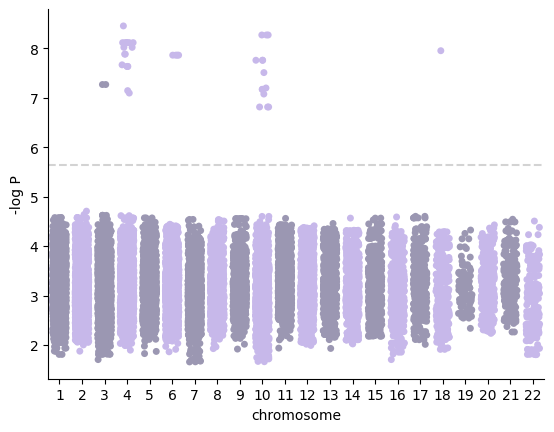

In [42]:
order = [str(i) for i in range(1, 23)]
bonf_line = -np.log10(0.05/len(assoc_qc))

sns.stripplot(x="#CHROM", y="-log P", data=assoc_qc, order=order, jitter=0.3, 
               palette=sns.color_palette(["#9B97B2", "#C7B8EA"]*11))

plt.axhline(y=bonf_line, linestyle="--", color="lightgrey") 
plt.xlabel("chromosome")
sns.despine()
plt.show()

In [93]:
assoc_qc.sort_values(by="P").iloc[0:10]

,#CHROM,POS,ID,REF,ALT,PROVISIONAL_REF?,A1,OMITTED,A1_FREQ,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,name,bonferroni,-log P
43704,11,25750000,c825264_11,1,2,Y,2,1,0.010098,N,REC,7378,315.091,1.27837,4.50015,0.000007,.,c825264_11_11,False,5.168092
44037,11,26000000,c23211_11,1,2,Y,2,1,0.010436,N,REC,7378,315.091,1.27837,4.50015,0.000007,.,c23211_11_11,False,5.168092
43453,11,25500000,c824065_11,1,2,Y,2,1,0.009894,N,REC,7378,315.091,1.27837,4.50015,0.000007,.,c824065_11_11,False,5.168092
44490,11,26250000,c25478_11,1,2,Y,2,1,0.010843,N,REC,7378,485.847,1.37499,4.49887,0.000007,.,c25478_11_11,False,5.165471
45155,11,26750000,c28401_11,1,2,Y,2,1,0.010436,N,REC,7378,485.847,1.37499,4.49887,0.000007,.,c28401_11_11,False,5.165471
44799,11,26500000,c26850_11,1,2,Y,2,1,0.010369,N,REC,7378,485.847,1.37499,4.49887,0.000007,.,c26850_11_11,False,5.165471
45494,11,27000000,c29980_11,1,2,Y,2,1,0.010843,N,REC,7378,485.847,1.37499,4.49887,0.000007,.,c29980_11_11,False,5.165471
40779,11,24000000,c810118_11,1,2,Y,2,1,0.012198,N,REC,7378,434.062,1.35305,4.48852,0.000007,.,c810118_11_11,False,5.144354
41917,11,24750000,c815950_11,1,2,Y,2,1,0.013486,N,REC,7378,294.571,1.26965,4.47803,0.000008,.,c815950_11_11,False,5.123005
41593,11,24500000,c814333_11,1,2,Y,2,1,0.012876,N,REC,7378,294.571,1.26965,4.47803,0.000008,.,c814333_11_11,False,5.123005


In [71]:
# frq[frq["name"] == "c527758_9_9"]

In [72]:
# case_frq[case_frq["name"] == "c527758_9_9"]

In [33]:
# map_file = pd.read_csv("dash_output/pr/adv_default/cluster2_10.map", sep=" ", header=None)
map_file = pd.read_csv("icurl/libd/aj/cluster1_1.map", sep=" ", header=None)
# frq_file = pd.read_csv("comparison/bc/icurl/aj_17.gcount", sep="\t")
# case_frq_file = pd.read_csv("comparison/bc/icurl/aj_17_case.gcount", sep="\t")
# map_file["size"] = map_file[3] - map_file[2]
map_file["region"] = "chr" + map_file[0].astype(str) + ":" + map_file[2].astype(str) + "-" + map_file[3].astype(str)

In [34]:
map_file[map_file[1] == "c1347690_1" ]

,0,1,2,3,region
279632,1,c1347690_1,237250001,237500000,chr1:237250001-237500000


In [35]:
# case_frq_file.sort_values(by="TWO_ALT_GENO_CTS", ascending=False).head(n=10)

In [244]:
snp = "c44155_17"

In [139]:
map_file[map_file[1] == snp]

,0,1,2,3,size,region
9281,17,c44155_17,40500001,40750000,249999,chr17:40500001-40750000


In [140]:
frq_file[frq_file["ID"] == snp]

,#CHROM,ID,REF,ALT,PROVISIONAL_REF?,HOM_REF_CT,HET_REF_ALT_CTS,TWO_ALT_GENO_CTS,HAP_REF_CT,HAP_ALT_CTS,MISSING_CT
48240,17,c44155_17,1,2,Y,3969,25,0,0,0,0


In [141]:
case_frq_file[case_frq_file["ID"] == snp]

,#CHROM,ID,REF,ALT,PROVISIONAL_REF?,HOM_REF_CT,HET_REF_ALT_CTS,TWO_ALT_GENO_CTS,HAP_REF_CT,HAP_ALT_CTS,MISSING_CT
48240,17,c44155_17,1,2,Y,413,11,0,0,0,0


In [142]:
case_frq_file.sort_values(by="TWO_ALT_GENO_CTS", ascending=False).head(n=10)

,#CHROM,ID,REF,ALT,PROVISIONAL_REF?,HOM_REF_CT,HET_REF_ALT_CTS,TWO_ALT_GENO_CTS,HAP_REF_CT,HAP_ALT_CTS,MISSING_CT
112367,17,c374400_17,1,2,Y,411,11,2,0,0,0
111900,17,c372142_17,1,2,Y,413,9,2,0,0,0
48208,17,c44104_17,1,2,Y,421,2,1,0,0,0
41420,17,c534509_17,1,2,Y,419,4,1,0,0,0
58207,17,c90794_17,1,2,Y,422,1,1,0,0,0
46934,17,c38085_17,1,2,Y,407,16,1,0,0,0
45545,17,c31019_17,1,2,Y,421,2,1,0,0,0
15147,17,c410001_17,1,2,Y,421,2,1,0,0,0
56138,17,c81565_17,1,2,Y,422,1,1,0,0,0
46940,17,c38092_17,1,2,Y,413,10,1,0,0,0


In [68]:
# case_frq.sort_values(by="TWO_ALT_GENO_CTS", ascending=False)

In [202]:
# geno = pd.read_csv("comparison/height/dashcc/cluster2_1.raw", sep=" ")
# pheno = pd.read_csv("output_regenie/cluster2/height_pheno.txt", sep="\t")
# geno_pheno = geno.merge(pheno, on="FID") 

In [137]:
# geno_pheno[f"{snp}_2"].value_counts()

In [138]:
# sns.boxplot(x=f"{snp}_2", y="height", data=geno_pheno, boxprops=dict(alpha=0.4),
#             palette=sns.color_palette(["#9B97B2", "#C7B8EA", "#D8A7CA"]))
# sns.stripplot(x=f"{snp}_2", y="height", data=geno_pheno, alpha=1,
#              palette=sns.color_palette(["#9B97B2", "#C7B8EA", "#D8A7CA"]))
# plt.xlabel("genotype")
# plt.ylabel("height z-score")
# plt.show() 

In [19]:
g = pd.read_csv("comparison/occ/dashcc/cluster2_9.raw", sep=" ")

In [21]:
g[g["cs78505_2"] == 2]

,FID,IID,PAT,MAT,SEX,PHENOTYPE,cs78505_2,cs43692_2
2677,199817,199817,0,0,0,1,2,2
2711,201431,201431,0,0,0,2,2,2
4165,25408,25408,0,0,0,1,2,2
